In [1]:
### LOAD DATASET AND CALIBRATION FILE 

from my_utils.my_vbr_dataset import vbrDataset, load_calibration, generate_depth_and_scene_maps
from my_utils.mast3r_utils import get_master_output, get_mast3r_image_shape, scale_intrinsics, overlap,plot_depth_overlay_on_image,plot_lidar_mast3r_matches
import cv2
dataset = vbrDataset(
    '/datasets/vbr_slam/spagna/spagna_train0_kitti', #path to dataset in kitti format
    '/datasets/vbr_slam/spagna/spagna_train0/spagna_train0_gt.txt' #path to ground truth file
)
calib = load_calibration('/datasets/vbr_slam/spagna/spagna_train0/vbr_calib.yaml') #load calibration file
K = calib['cam_l']['K']
T_base_cam = calib['cam_l']['T_base_cam']
T_cam_lidar = calib['cam_l']['T_cam_lidar']

### LOAD MAST3R MODEL AND INFERENCE UTILITIES
from mast3r.model import AsymmetricMASt3R
#load model
device = 'cuda:4'
model_name = "naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric"
model = AsymmetricMASt3R.from_pretrained(model_name).to(device)

In [7]:
print(len(dataset))

42435


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def show_image_pair(anchor_img, query_img, anchor_idx=None, query_idx=None, figsize=(12, 6), titles=None):
    """
    Display anchor and query images side by side.
    """
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.imshow(query_img)
    title = f'Query {query_idx}' if query_idx is not None else 'Query'
    if titles and len(titles) > 0:
        title = titles[0]
    plt.title(title)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(anchor_img)
    title = f'Anchor {anchor_idx}' if anchor_idx is not None else 'Anchor'
    if titles and len(titles) > 1:
        title = titles[1]
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()



def plot_pointclouds_top_view(pointclouds, labels=None, colors=None, s=10, alpha=0.5, title=None, ax=None):
    """
    Plot multiple point clouds in top-down (X-Z) view.
    pointclouds: list of (N,3) arrays
    labels: list of strings
    colors: list of colors
    """
    if not isinstance(pointclouds, list):
        pointclouds = [pointclouds]
    if labels is None:
        labels = [f"Cloud {i}" for i in range(len(pointclouds))]
    if colors is None:
        colors = ['blue', 'orange', 'green', 'red', 'purple']
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    for i, pts in enumerate(pointclouds):
        if pts is not None and pts.size > 0:
            ax.scatter(pts[:, 0], pts[:, 2], c=colors[i % len(colors)], s=s, marker='o', alpha=alpha, label=labels[i])
    ax.set_xlabel('X (Right)')
    ax.set_ylabel('Z (Forward)')
    ax.set_title(title if title else 'Top-View of Point Clouds')
    ax.axis('equal')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

/home/bjangley/VPR/mast3r-v2/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/bjangley/VPR/mast3r-v2/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/bjangley/VPR/mast3r-v2/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


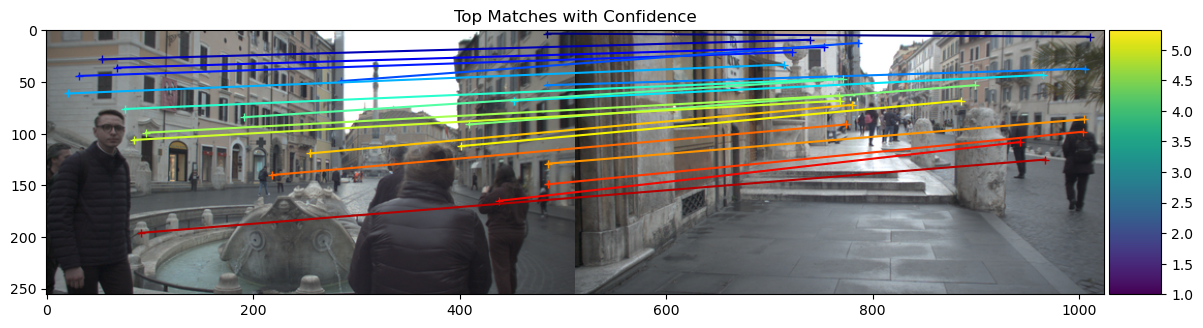

Fundamental matrix: 813 matches, 668 inliers, 145 outliers
Fundamental matrix: 813 matches, 668 inliers, 145 outliers


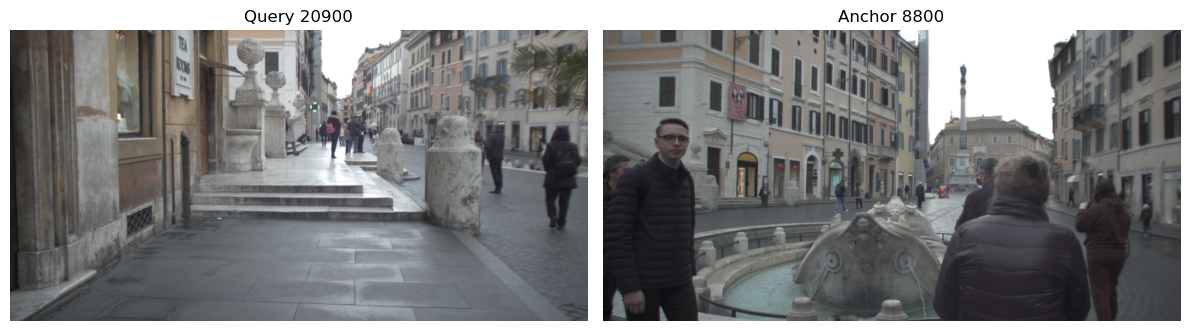

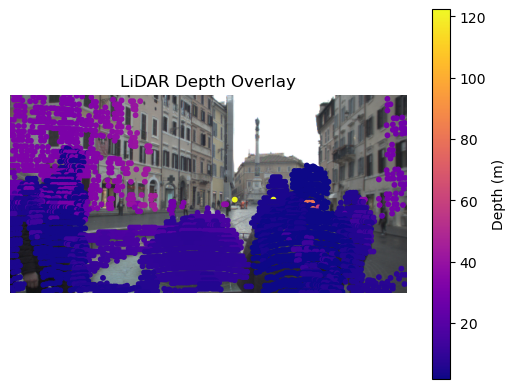

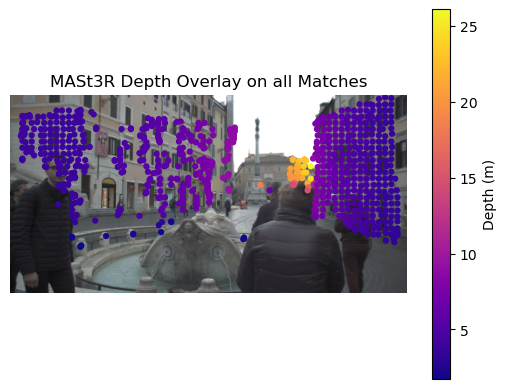

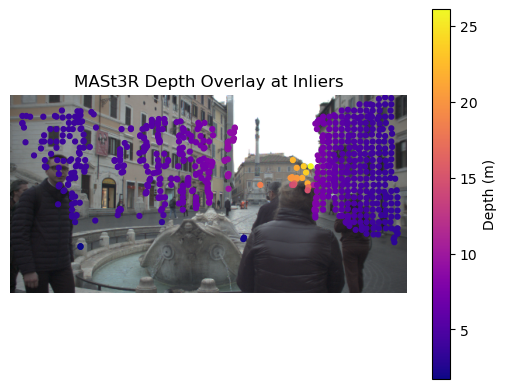

Recovered 121 matches with depth
Number of inlier matches: 121


In [9]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from scipy.spatial.transform import Rotation as Rscipy

# --- Load anchor-query pair ---
# pairs_df = pd.read_csv('/home/bjangley/VPR/mast3r-v2/results2/spagna_matches_inliers_fm_top3.csv')
# anchor_idx, query_idx = int(row['anchor_idx']), int(row['query_idx'])

anchor_idx, query_idx =  8800, 20900
anchor = dataset[anchor_idx]
query  = dataset[query_idx]
gt_pose = query['pose']

# --- Run MASt3R model and extract matches ---
output = get_master_output(
    model, device,
    anchor['image_left'],
    query['image_left'],
    visualize=True,
    verbose=False
)
matches_im0 = output[0]
matches_im1 = output[1]
pts3d_im0   = output[2]

# --- find number of inliers from the matches ---
if len(matches_im0) >= 8:
    F, mask_f = cv2.findFundamentalMat(matches_im0, matches_im1, cv2.FM_RANSAC, 1, 0.99)
    num_inliers_f = int(mask_f.sum()) if mask_f is not None else 0
    inlier_mask = mask_f.ravel().astype(bool)
    inlier_im0 = matches_im0[inlier_mask]
    inlier_im1 = matches_im1[inlier_mask]
else:
    num_inliers_f = 0
    inlier_im0 = np.empty((0, 2))
    inlier_im1 = np.empty((0, 2))
print(f"Fundamental matrix: {len(matches_im0)} matches, {num_inliers_f} inliers, {len(matches_im0) - num_inliers_f} outliers")


# --- find number of inliers from the matches ---
if len(matches_im0) >= 8:
    F, mask_f = cv2.findFundamentalMat(matches_im1,matches_im0, cv2.FM_RANSAC, 1, 0.99)
    num_inliers_f = int(mask_f.sum()) if mask_f is not None else 0
    inlier_mask = mask_f.ravel().astype(bool)
    inlier_im0 = matches_im0[inlier_mask]
    inlier_im1 = matches_im1[inlier_mask]
else:
    num_inliers_f = 0
    inlier_im0 = np.empty((0, 2))
    inlier_im1 = np.empty((0, 2))
print(f"Fundamental matrix: {len(matches_im0)} matches, {num_inliers_f} inliers, {len(matches_im0) - num_inliers_f} outliers")



# --- LiDAR projection and image resizing ---
img = cv2.imread(anchor['image_left'])
H, W = img.shape[:2]
mast3r_w, mast3r_h = get_mast3r_image_shape(W, H)
K_new = scale_intrinsics(K, W, H, mast3r_w, mast3r_h)
depth_map, scene_map = generate_depth_and_scene_maps(anchor['lidar_points'], K_new, T_cam_lidar, (mast3r_h, mast3r_w))

# --- Load and show anchor/query images ---
anchor_img = Image.open(anchor['image_left'])
query_img = Image.open(query['image_left'])
show_image_pair(anchor_img, query_img, anchor_idx, query_idx)

# --- LiDAR depth overlay ---
img_orig = plt.imread(anchor['image_left'])
img_resized = cv2.resize(img_orig, (mast3r_w, mast3r_h))
img_resized = img_resized.astype(np.float32) / 255.0 if img_resized.dtype == np.uint8 else img_resized
v, u = np.where(np.isfinite(depth_map))
pixel_uv = np.stack((u, v), axis=-1)
plot_depth_overlay_on_image(img_resized, scene_map, pixel_uv, point_size=10, alpha=1.0, title="LiDAR Depth Overlay")

# --- MASt3R 3D points overlay ---
if len(matches_im0) > 0:
    plot_depth_overlay_on_image(
        img_resized,
        pts3d_im0,
        matches_im0,
        point_size=12,
        cmap='plasma',
        alpha=1.0,
        title="MASt3R Depth Overlay on all Matches"
    )
if num_inliers_f > 0:
    plot_depth_overlay_on_image(
        img_resized,
        pts3d_im0,
        inlier_im0,
        point_size=12,
        cmap='plasma',
        alpha=1.0,
        title="MASt3R Depth Overlay at Inliers"
    )

# --- Overlap between inlier keypoints and LiDAR depth map ---

matched_uv, matched_lidar_uv, matched_indices = overlap(inlier_im0, depth_map, max_pixel_dist=2)
inlier_im0 = inlier_im0[matched_indices]
inlier_im1 = inlier_im1[matched_indices]
print(f"Recovered {len(matched_uv)} matches with depth")
print(f"Number of inlier matches: {len(inlier_im0)}")


# # --- Plot top-down view of point clouds ---
# plot_pointclouds_top_view(
#     [lidar_pts, master_pts, master_pts_scaled],
#     labels=['LiDAR', 'MASt3R', 'Scaled MASt3R'],
#     colors=['blue', 'orange', 'green'],
#     title='Top-Down View: Matched LiDAR and MASt3R Points'
# )

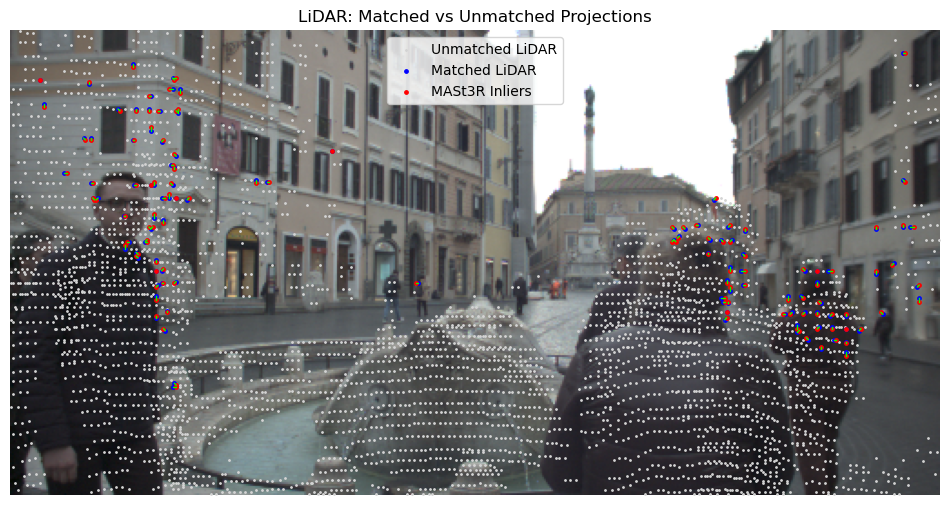

In [5]:
def plot_lidar_mast3r_matches(img, lidar_uv, matched_lidar_uv, inliers_im0, title="LiDAR: Matched vs Unmatched Projections"):
    """
    Visualize matched/unmatched LiDAR projections and MASt3R inlier matches.

    Args:
        img: Image array (background for scatter plot)
        lidar_uv: (N,2) array of all valid LiDAR-projected pixel coordinates
        matched_lidar_uv: (M,2) array of matched LiDAR pixel coordinates
        inliers_im0: (M,2) array of MASt3R inlier keypoints (matched to LiDAR)
        title: Plot title
    """
    import matplotlib.pyplot as plt
    import numpy as np

    matched_lidar_uv_set = set(map(tuple, matched_lidar_uv))
    mask_matched = np.array([tuple(uv) in matched_lidar_uv_set for uv in lidar_uv])
    lidar_matched_uv = lidar_uv[mask_matched]
    lidar_unmatched_uv = lidar_uv[~mask_matched]

    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    if len(lidar_unmatched_uv) > 0:
        plt.scatter(lidar_unmatched_uv[:, 0], lidar_unmatched_uv[:, 1], c='lightgray', s=1, label='Unmatched LiDAR')
    if len(lidar_matched_uv) > 0:
        plt.scatter(lidar_matched_uv[:, 0], lidar_matched_uv[:, 1], c='blue', s=6, label='Matched LiDAR')
    if len(inliers_im0) > 0:
        plt.scatter(inliers_im0[:, 0], inliers_im0[:, 1], c='red', s=6, label='MASt3R Inliers')
        # Draw lines between inlier keypoints and matched LiDAR
        for match_uv, lidar_uv_ in zip(inliers_im0, matched_lidar_uv):
            plt.plot([match_uv[0], lidar_uv_[0]], [match_uv[1], lidar_uv_[1]], color='lime', linewidth=1)
    plt.title(title)
    plt.axis('off')
    plt.legend()
    plt.show()


# Prepare lidar_uv as before
v_all, u_all = np.where(np.isfinite(depth_map))
lidar_uv = np.stack((u_all, v_all), axis=-1)

plot_lidar_mast3r_matches(
    img_resized,
    lidar_uv,
    matched_lidar_uv,
    inlier_im0
)

In [6]:
# Compute all localizations for the loaded anchor-query pair
from my_utils.scaling import compute_scaled_points
from my_utils.mast3r_utils import solve_pnp, se3_to_pose, pose_to_se3

# --- Prepare inlier 3D-2D correspondences ---
if len(inlier_im0) >= 4:
    mast3r_pts = pts3d_im0[inlier_im0[:, 1].astype(int), inlier_im0[:, 0].astype(int)]
    lidar_pts = scene_map[matched_lidar_uv[:, 1].astype(int), matched_lidar_uv[:, 0].astype(int)]
    inlier_2d = inlier_im1.astype(np.float32)
else:
    mast3r_pts = np.empty((0, 3))
    lidar_pts = np.empty((0, 3))
    inlier_2d = np.empty((0, 2))

T_anchor_local = pose_to_se3(anchor['pose'])

# --- PnP from MASt3R ---
T_query_anchor_mast3r = solve_pnp(mast3r_pts, inlier_2d, K_new) if len(mast3r_pts) >= 4 else None
if T_query_anchor_mast3r is not None:
    T_m_local = T_anchor_local @ T_base_cam @ np.linalg.inv(T_query_anchor_mast3r)
    pose_m = se3_to_pose(T_m_local)  # Convert to [tx, ty, tz, qx, qy, qz, qw]

# --- PnP from LiDAR ---
T_query_anchor_lidar = solve_pnp(lidar_pts, inlier_2d, K_new) if len(lidar_pts) >= 4 else None
if T_query_anchor_lidar is not None:
    T_l_local = T_anchor_local @ T_base_cam @ np.linalg.inv(T_query_anchor_lidar)
    pose_l = se3_to_pose(T_l_local)  # Convert to [tx, ty, tz, qx, qy, qz, qw]

# --- MASt3R scaled v3 (L1 centroid scale) ---
mast3r_pts_scaled_v3, scale_v3 = compute_scaled_points('v3', mast3r_pts, lidar_pts) if len(mast3r_pts) >= 4 and len(lidar_pts) >= 4 else (np.empty((0, 3)), None)
if scale_v3 is not None:
    print(f"Scale estimated for v3 (L1 centroid scale): {scale_v3}")
T_query_anchor_scaled_v3 = solve_pnp(mast3r_pts_scaled_v3, inlier_2d, K_new) if mast3r_pts_scaled_v3.size > 0 else None
if T_query_anchor_scaled_v3 is not None:
    T_s3_local = T_anchor_local @ T_base_cam @ np.linalg.inv(T_query_anchor_scaled_v3)
    pose_s3 = se3_to_pose(T_s3_local)  # Convert to [tx, ty, tz, qx, qy, qz, qw]

# --- MASt3R scaled v4 (per-axis L1 scale) ---
mast3r_pts_scaled_v4, scale_v4 = compute_scaled_points('v4', mast3r_pts, lidar_pts) if len(mast3r_pts) >= 4 and len(lidar_pts) >= 4 else (np.empty((0, 3)), None)
if scale_v4 is not None:
    print(f"Scale estimated for v4 (per-axis L1 scale): {scale_v4}")
T_query_anchor_scaled_v4 = solve_pnp(mast3r_pts_scaled_v4, inlier_2d, K_new) if mast3r_pts_scaled_v4.size > 0 else None
if T_query_anchor_scaled_v4 is not None:
    T_s4_local = T_anchor_local @ T_base_cam @ np.linalg.inv(T_query_anchor_scaled_v4)
    pose_s4 = se3_to_pose(T_s4_local)  # Convert to [tx, ty, tz, qx, qy, qz, qw]

# --- MASt3R scaled ICP (Umeyama) ---
mast3r_pts_scaled_icp, scale_icp = compute_scaled_points('icp', mast3r_pts, lidar_pts) if len(mast3r_pts) >= 4 and len(lidar_pts) >= 4 else (np.empty((0, 3)), None)
if scale_icp is not None:
    print(f"Scale estimated for ICP (Umeyama): {scale_icp}")
T_query_anchor_scaled_icp = solve_pnp(mast3r_pts_scaled_icp, inlier_2d, K_new) if mast3r_pts_scaled_icp.size > 0 else None
if T_query_anchor_scaled_icp is not None:
    T_icp_local = T_anchor_local @ T_base_cam @ np.linalg.inv(T_query_anchor_scaled_icp)
    pose_icp = se3_to_pose(T_icp_local)  # Convert to [tx, ty, tz, qx, qy, qz, qw]

# --- Plot all estimates ---
from my_utils.plotting import plot_all_estimates_for_query

results_dicts = {}
if 'pose_m' in locals() and pose_m is not None:
    results_dicts['MASt3R'] = ({query_idx: [(anchor_idx, pose_m)]}, {'anchor': 'black', 'estimate': 'orange'})
if 'pose_l' in locals() and pose_l is not None:
    results_dicts['LiDAR'] = ({query_idx: [(anchor_idx, pose_l)]}, {'anchor': 'black', 'estimate': 'blue'})
if 'pose_s3' in locals() and pose_s3 is not None:
    results_dicts['MASt3R v3'] = ({query_idx: [(anchor_idx, pose_s3)]}, {'anchor': 'black', 'estimate': 'green'})
if 'pose_s4' in locals() and pose_s4 is not None:
    results_dicts['MASt3R v4'] = ({query_idx: [(anchor_idx, pose_s4)]}, {'anchor': 'black', 'estimate': 'purple'})
if 'pose_icp' in locals() and pose_icp is not None:
    results_dicts['MASt3R v5'] = ({query_idx: [(anchor_idx, pose_icp)]}, {'anchor': 'black', 'estimate': 'red'})

plot_all_estimates_for_query(query_idx, dataset, results_dicts, styles=None)

ImportError: cannot import name 'se3_to_pose' from 'my_utils.mast3r_utils' (/home/bjangley/VPR/mast3r-v2/my_utils/mast3r_utils.py)

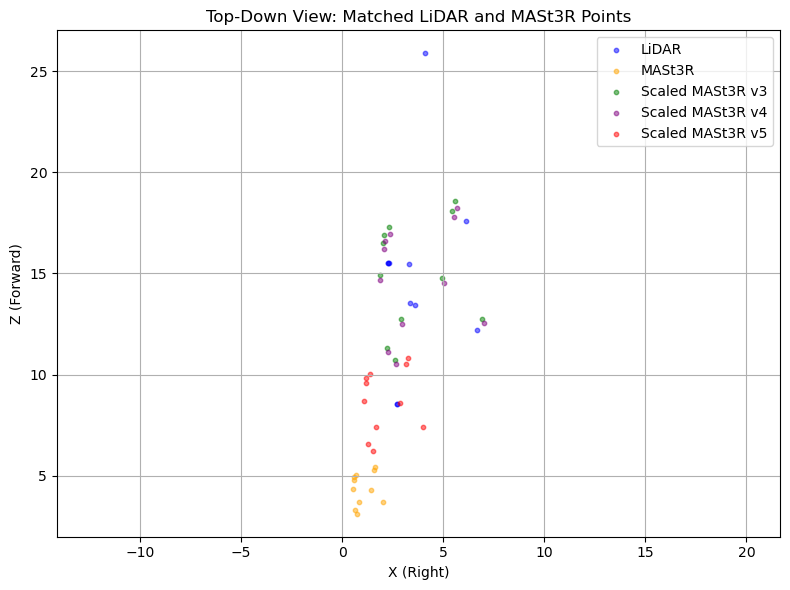

In [ ]:
# --- Plot top-down view of point clouds ---
plot_pointclouds_top_view(
    [lidar_pts, mast3r_pts, mast3r_pts_scaled_v3, mast3r_pts_scaled_v4, mast3r_pts_scaled_icp],
    labels=['LiDAR', 'MASt3R', 'Scaled MASt3R v3', 'Scaled MASt3R v4', 'Scaled MASt3R v5'],
    colors=['blue', 'orange', 'green', 'purple', 'red'],
    title='Top-Down View: Matched LiDAR and MASt3R Points'
)

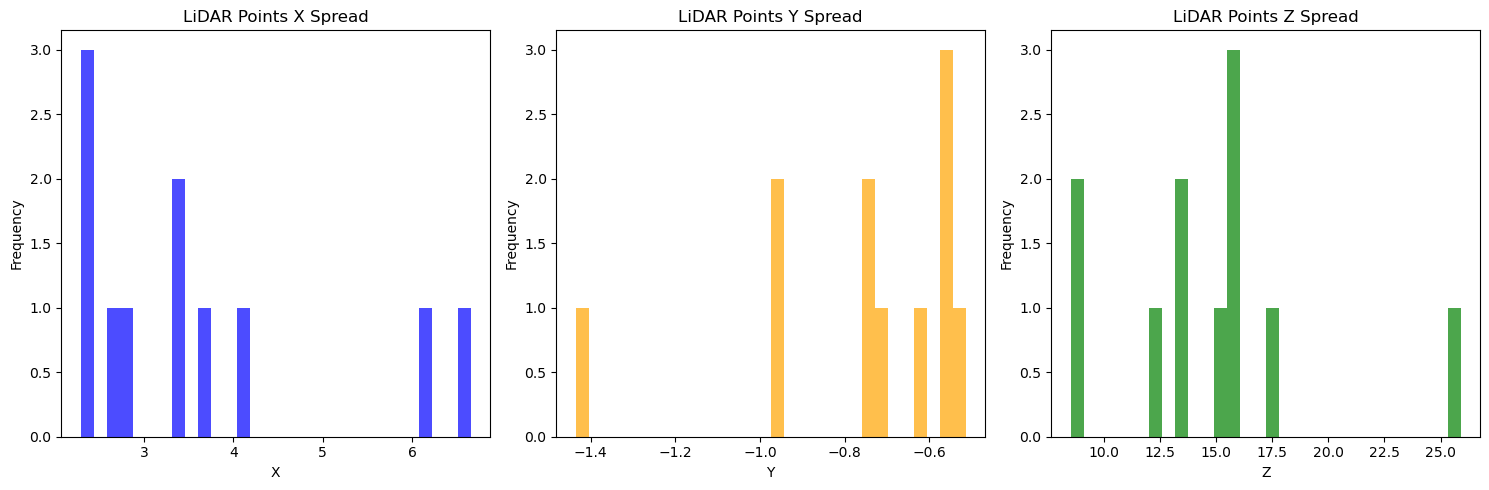

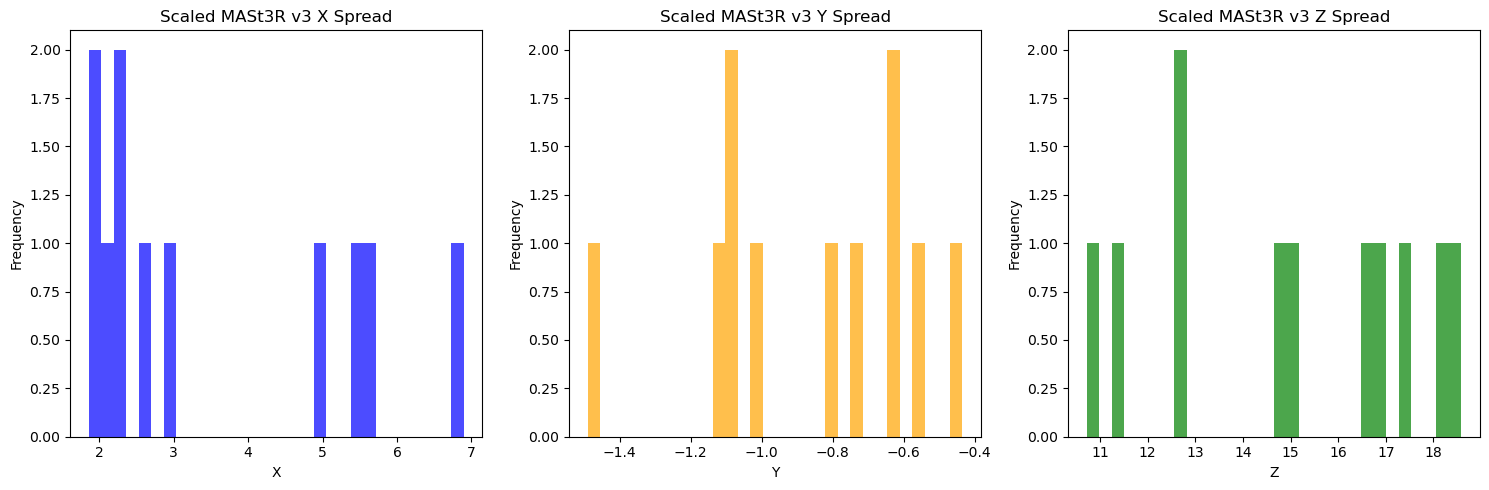

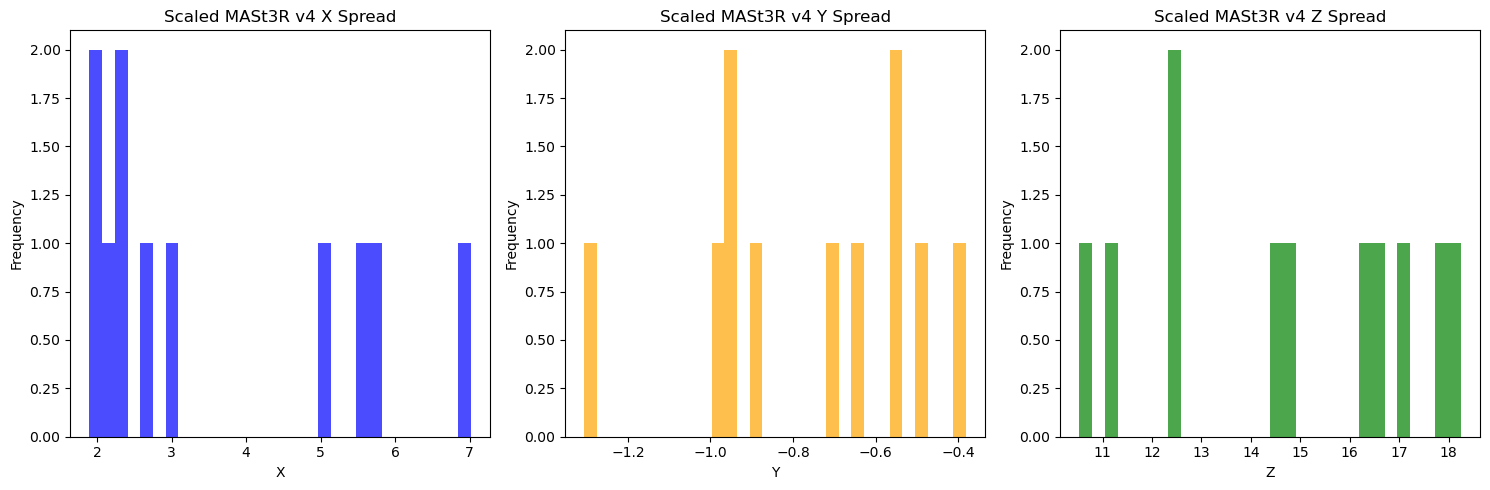

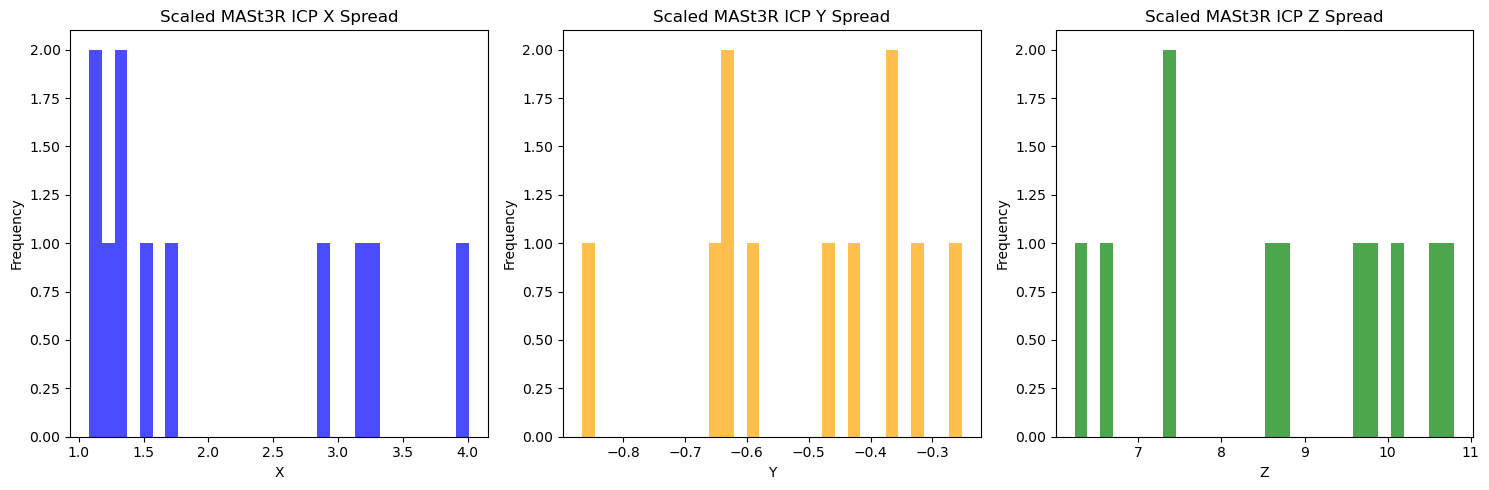

In [ ]:
import matplotlib.pyplot as plt

def plot_histograms(points, title_prefix):
    """
    Plot histograms for the spread of x, y, z points in a point cloud.
    Args:
        points: (N, 3) array of point cloud coordinates.
        title_prefix: Prefix for the histogram titles.
    """
    if points.size > 0:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].hist(points[:, 0], bins=30, color='blue', alpha=0.7)
        axes[0].set_title(f'{title_prefix} X Spread')
        axes[0].set_xlabel('X')
        axes[0].set_ylabel('Frequency')

        axes[1].hist(points[:, 1], bins=30, color='orange', alpha=0.7)
        axes[1].set_title(f'{title_prefix} Y Spread')
        axes[1].set_xlabel('Y')
        axes[1].set_ylabel('Frequency')

        axes[2].hist(points[:, 2], bins=30, color='green', alpha=0.7)
        axes[2].set_title(f'{title_prefix} Z Spread')
        axes[2].set_xlabel('Z')
        axes[2].set_ylabel('Frequency')

        plt.tight_layout()
        plt.show()
    else:
        print(f"No points available for {title_prefix}.")

# Plot histograms for each scaled point cloud
plot_histograms(lidar_pts, "LiDAR Points")
plot_histograms(mast3r_pts_scaled_v3, "Scaled MASt3R v3")
plot_histograms(mast3r_pts_scaled_v4, "Scaled MASt3R v4")
plot_histograms(mast3r_pts_scaled_icp, "Scaled MASt3R ICP")